# Tower of Hanoi, lösning:

In [19]:
def hanoi_dynamic(n, from_rod, to_rod, aux_rod, memo):
    """
    Tower of Hanoi problem using dynamic programming.

    n: Number of disks
    from_rod: The start rod
    to_rod: The target rod
    aux_rod: The auxiliary rod
    memo: Dictionary to memoize the solutions
    """
    if n == 0:
        return []

    if (n, from_rod, to_rod, aux_rod) in memo:
        return memo[(n, from_rod, to_rod, aux_rod)]

    moves = []

    # Move n - 1 disks from start to auxiliary
    moves += hanoi_dynamic(n - 1, from_rod, aux_rod, to_rod, memo)

    # Move the nth disk from start to target
    moves.append((from_rod, to_rod))

    # Move the n - 1 disks from auxiliary to target
    moves += hanoi_dynamic(n - 1, aux_rod, to_rod, from_rod, memo)

    memo[(n, from_rod, to_rod, aux_rod)] = moves
    return moves

# Memoization dictionary
memo = {}

# Get the sequence of moves for 3 disks using dynamic programming
optimal_moves_dynamic = hanoi_dynamic(3, 'A', 'C', 'B', memo)
optimal_moves_dynamic


[('A', 'C'),
 ('A', 'B'),
 ('C', 'B'),
 ('A', 'C'),
 ('B', 'A'),
 ('B', 'C'),
 ('A', 'C')]

# TEST med chatgpt:

In [38]:
class TowerOfHanoiDP:
    def __init__(self):
        self.moves_memo = {}

    def toh(self, disks, source, destination, auxiliary, current_state):
        # If we reached the goal state, return an empty list of moves
        if current_state == ((), (), tuple(range(disks, 0, -1))):
            return []

        # Check if we already have a solution for this state
        if current_state in self.moves_memo:
            return self.moves_memo[current_state]

        # If there are no disks to move, return an empty list of moves
        if disks == 0:
            return []

        # Attempt to move the largest disk from the source to the destination
        moves = []
        source_rod, auxiliary_rod, destination_rod = current_state
        if source_rod and (not destination_rod or source_rod[-1] < destination_rod[-1]):
            # Move the top disk from source to destination
            new_destination = destination_rod + (source_rod[-1],)
            new_source = source_rod[:-1]
            # Solve the subproblem
            moves += [(source, destination)] + self.toh(disks-1, auxiliary, destination, source,
                                                       (new_source, auxiliary_rod, new_destination))

        # Attempt to move the largest disk from the source to the auxiliary
        if source_rod and (not auxiliary_rod or source_rod[-1] < auxiliary_rod[-1]):
            # Move the top disk from source to auxiliary
            new_auxiliary = auxiliary_rod + (source_rod[-1],)
            new_source = source_rod[:-1]
            # Solve the subproblem
            moves += [(source, auxiliary)] + self.toh(disks-1, destination, auxiliary, source,
                                                      (new_source, new_auxiliary, destination_rod))

        # Memoize the solution
        self.moves_memo[current_state] = moves

        return moves

    def solve_hanoi(self, disks, current_state):
        source, auxiliary, destination = 'A', 'B', 'C'
        return self.toh(disks, source, destination, auxiliary, current_state)

# Example usage for a custom starting state (each tuple represents the disks on rods A, B, and C):
custom_start_state = (('123', '', ''),  # Initial configuration
                      ('', '', '123'),  # Goal configuration
                      ('', '123', ''))  # Another possible configuration

# Initialize the solver
hanoi_solver = TowerOfHanoiDP()
disks = 3  # Number of disks

# Solve for each custom starting state
for state in custom_start_state:
    # Parse the state into the format the solver expects (tuples of ints)
    parsed_state = tuple(tuple(int(disk) for disk in rod) for rod in state)
    solution_moves = hanoi_solver.solve_hanoi(disks, parsed_state)
    print(f"Solution for state {state}:")
    for move in solution_moves:
        print(f"Move disk from rod {move[0]} to rod {move[1]}")
    print()

Solution for state ('123', '', ''):
Move disk from rod A to rod C
Move disk from rod B to rod C
Move disk from rod A to rod C
Move disk from rod A to rod B
Move disk from rod B to rod A
Move disk from rod C to rod A
Move disk from rod C to rod B
Move disk from rod A to rod B
Move disk from rod C to rod B
Move disk from rod A to rod B
Move disk from rod A to rod C
Move disk from rod C to rod A
Move disk from rod B to rod A
Move disk from rod B to rod C

Solution for state ('', '', '123'):

Solution for state ('', '123', ''):



# Test med q-learning från github repon:

In [21]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
class TowersOfHanoi:
    def __init__(self, state):
        self.state = state              # "State" is a tuple of length N, where N is the number of discs, and the elements are peg indices in [0,1,2]
        self.discs = len(self.state)

    def discs_on_peg(self, peg):
        return [disc for disc in range(self.discs) if self.state[disc] == peg]

    def move_allowed(self, move):
        discs_from = self.discs_on_peg(move[0])
        discs_to = self.discs_on_peg(move[1])
        if discs_from:
            return (min(discs_to) > min(discs_from)) if discs_to else True
        else:
            return False

    def get_moved_state(self, move):
        if self.move_allowed(move):
            disc_to_move = min(self.discs_on_peg(move[0]))
        moved_state = list(self.state)
        moved_state[disc_to_move] = move[1]
        return tuple(moved_state)

In [23]:
# Generates the reward matrix for the Towers of Hanoi game as a Pandas DataFrame
def generate_reward_matrix(N):      # N is the number of discs
    states = list(itertools.product(list(range(3)), repeat=N))
    moves = list(itertools.permutations(list(range(3)), 2))
    R = pd.DataFrame(index=states, columns=states, data=-np.inf)
    for state in states:
        tower = TowersOfHanoi(state=state)
        for move in moves:
            if tower.move_allowed(move):
                next_state = tower.get_moved_state(move)
                R[state][next_state] = 0
    final_state = tuple([2]*N)          # Define final state as all discs being on the last peg
    R[final_state] += 100               # Add a reward for all moves leading to the final state
    return R.values

In [24]:
def learn_Q(R, gamma=0.8, alpha=1.0, N_episodes=1000):
    Q = np.zeros(R.shape)
    states=list(range(R.shape[0]))
    for n in range(N_episodes):
        Q_previous = Q
        state = np.random.choice(states)                # Randomly select initial state
        next_states = np.where(R[state,:] >= 0)[0]      # Generate a list of possible next states
        next_state = np.random.choice(next_states)      # Randomly select next state from the list of possible next states
        V = np.max(Q[next_state,:])                     # Maximum Q-value of the states accessible from the next state
        Q[state, next_state] = (1-alpha)*Q[state, next_state] + alpha*(R[state, next_state] + gamma*V)      # Update Q-values
    if np.max(Q) > 0:
        Q /= np.max(Q)      # Normalize Q to its maximum value
    return Q

In [25]:
def get_policy(Q, R):
    Q_allowed = pd.DataFrame(Q)[pd.DataFrame(R) >= 0].values
    policy = []
    for i in range(Q_allowed.shape[0]):
        row = Q_allowed[i,:]
        sorted_vals = np.sort(row)
        sorted_vals = sorted_vals[~np.isnan(sorted_vals)][::-1]
        sorted_args = row.argsort()[np.where(~np.isnan(sorted_vals))][::-1]

        max_vals = [val for val in sorted_vals if val==sorted_vals[0]]
        max_args = [sorted_args[i] for i,val in enumerate(sorted_vals) if val==sorted_vals[0]]
        policy.append(max_args)
    return policy

In [26]:
def play(policy):
    start_state = 0
    end_state = len(policy)-1
    state = start_state
    moves = 0
    while state != end_state:
        state = np.random.choice(policy[state])
        moves += 1
    return moves

In [27]:
def play_average(policy, play_times=100):
    moves = np.zeros(play_times)
    for n in range(play_times):
        moves[n] = play(policy)
    return np.mean(moves), np.std(moves)

def Q_performance(R, episodes, play_times=100):
    means = np.zeros(len(episodes))
    stds = np.zeros(len(episodes))
    for n, N_episodes in enumerate(episodes):
        Q = learn_Q(R, N_episodes = N_episodes)
        policy = get_policy(Q,R)
        means[n], stds[n] = play_average(policy, play_times)
    return means, stds

def Q_performance_average(R, episodes, learn_times = 100, play_times=100):
    means_times = np.zeros((learn_times, len(episodes)))
    stds_times = np.zeros((learn_times, len(episodes)))
    for n in range(learn_times):
        means_times[n,:], stds_times[n,:] = Q_performance(R, episodes, play_times=play_times)
    means_averaged = np.mean(means_times, axis = 0)
    stds_averaged = np.mean(stds_times, axis = 0)
    return means_averaged, stds_averaged

In [28]:
def plot_results(episodes, means_averaged, stds_averaged, N, block=False):
    fig = plt.figure()
    plt.loglog(episodes, means_averaged,'b.-',label='Average performance')
    plt.loglog(episodes, means_averaged + stds_averaged, 'b', alpha=0.5)
    plt.loglog(episodes, means_averaged - stds_averaged, 'b', alpha=0.5)
    plt.fill_between(episodes, means_averaged-stds_averaged, means_averaged+stds_averaged, facecolor='blue', alpha=0.5)
    optimum_moves = 2**N - 1
    plt.axhline(y=optimum_moves, color='g', label='Optimum (=%s moves)' % optimum_moves)
    plt.xlabel('Number of training episodes')
    plt.ylabel('Number of moves')
    plt.grid('on', which='both')
    plt.title('Q-learning the Towers of Hanoi game with %s discs' % N)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels)
    plt.show(block=block)

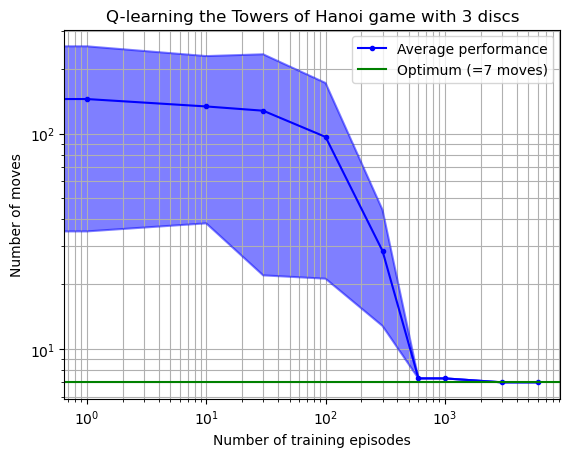

In [29]:
N = 3                                   # Number of discs in the Towers of Hanoi game
R = generate_reward_matrix(N)
episodes = [0, 1, 10, 30, 100, 300, 600, 1000, 3000, 6000]
means_averaged, stds_averaged = Q_performance_average(R, episodes, learn_times=10, play_times=10)
plot_results(episodes, means_averaged, stds_averaged, N)



# Källor

OpenAI. (2023). Code Generated by ChatGPT (4.0) [Code].
Notis. ChatGPT användes i arbetet för att speglas med och producera kod som resulterade i ett förbättrat program vilket inte skulle ha varit möjligt utan AI stöd.

https://github.com/khpeek/Q-learning-Hanoi